# Web scraping part 2: craigslist

## Lecture objectives

1. More practice with scraping web pages and parsing text
2. Learn how to handle errors ("exceptions") gracefully
3. More pratice with `pandas` and plotting

## Example: Scraping craigslist data
Craiglist provides a wealth of information on apartment rentals and other types of housing, as you can read about in the [Boeing and Waddell paper](https://journals.sagepub.com/doi/abs/10.1177/0739456X16664789). But short of clicking through lots of links, how do we access it?

As with any scraping project, the first step is to get an example web page, and see if we can reverse-engineer the structure.

One option is to parse each detailed post, with information on parking, desired qualities of roommates, etc. But a lot of information is actually in the [list of posts](https://losangeles.craigslist.org/search/lac/hhh). 

**Option 1**. You can download the most recent posts yourself.

In [1]:
import requests
from bs4 import BeautifulSoup

url = 'https://losangeles.craigslist.org/search/lac/hhh'
r = requests.get(url)

soup = BeautifulSoup(r.content)
print(soup.prettify())

<!DOCTYPE html>
<html>
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <meta content="craigslist" property="og:site_name"/>
  <meta content="preview" name="twitter:card"/>
  <meta content="central LA housing - craigslist" property="og:title"/>
  <meta content="central LA housing - craigslist" name="description"/>
  <meta content="central LA housing - craigslist" property="og:description"/>
  <meta content="https://losangeles.craigslist.org/search/lac/hhh" property="og:url"/>
  <meta content="true" name="smartbanner:api"/>
  <meta content="the craigslist app" name="smartbanner:title"/>
  <meta content="what's old is new" name="smartbanner:author"/>
  <meta content="/images/app_icon.png" name="smartbanner:icon-apple"/>
  <meta content="/images/app_icon.png" name="smartbanner:icon-google"/>
  <meta content="view" name="smartbanner:button"/>
  <meta content="close" name="smar

**Option 2.** You can access the same page as I show below, which I saved to the GitHub repository.

In [2]:
# this is how I saved it
#with open("craigslist_pages/craigslist.txt", "wb") as f:
#    f.write(r.content)

with open("craigslist_pages/craigslist.txt", "r") as f:
    saved_content = f.read()
    
# the saved_content variable now contains what I originally had in r.content
# so we can create a BeautifulSoup object in the same way
soup = BeautifulSoup(saved_content)
print(soup.prettify())

<!DOCTYPE html>
<html>
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <meta content="craigslist" property="og:site_name"/>
  <meta content="preview" name="twitter:card"/>
  <meta content="central LA housing - craigslist" property="og:title"/>
  <meta content="central LA housing - craigslist" name="description"/>
  <meta content="central LA housing - craigslist" property="og:description"/>
  <meta content="https://losangeles.craigslist.org/search/lac/hhh" property="og:url"/>
  <meta content="true" name="smartbanner:api"/>
  <meta content="the craigslist app" name="smartbanner:title"/>
  <meta content="what's old is new" name="smartbanner:author"/>
  <meta content="/images/app_icon.png" name="smartbanner:icon-apple"/>
  <meta content="/images/app_icon.png" name="smartbanner:icon-google"/>
  <meta content="view" name="smartbanner:button"/>
  <meta content="close" name="smar

Let's look at the output to figure out how to parse it.

Again, this takes some detective work and trial and error.

It looks like each post is in a `<li>` tag. Moreover, note that it's also in a `class` called `result-row`. Structured data like this make it much easier to scrape! The `find_all()` function takes an optional `class_` argument that can filter by class.

In [3]:
posts = soup.find_all('li', class_= 'result-row')

# Note that there are 120 results, which is the number of posts returned on the Craigslist webpage. 
# That's a good sign!
print(len(posts))


120


Let's look at a sample post.

In [4]:
posts[0]

<li class="result-row" data-pid="7462867093">
<a class="result-image gallery" data-ids="3:00x0x_hYj1h9Urou4z_05a03r,3:00m0m_lxq8kHsnewGz_05a03r,3:00q0q_lJfN76ZHs6Dz_0c60c6,3:00J0J_kDO26Oo9zJVz_05a03r,3:01414_9YJJ8lWgSDGz_05a03r,3:00z0z_6144zJkcPUSz_05a03r,3:00303_2kauOPexgjiz_05a03r,3:00u0u_1pXEjvo1UeHz_05a03r" href="https://losangeles.craigslist.org/lac/apa/d/los-angeles-dishwasher-outdoor/7462867093.html">
<span class="result-price">$2,363</span>
</a>
<div class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2022-03-31 14:12" title="Thu 31 Mar 02:12:22 PM">Mar 31</time>
<h3 class="result-heading">
<a class="result-title hdrlnk" data-id="7462867093" href="https://losangeles.craigslist.org/lac/apa/d/los-angeles-dishwasher-outdoor/7462867093.html" id="postid_7462867093">Dishwasher, Outdoor Fireplace, Built-in Microwave</a>
</h3>
<span class="result-meta">
<span class="resul

It looks like the price and the neighborhood have their own class, within the `span` tag. 
The title and URL look like they are within the `a` tag. The number of bedrooms is a bit more complicated, but it's somewhere in the housing class.

Let's test this out. Note that `find()` will get the first occurence.

In [5]:
print(posts[0].find('span', class_= 'result-price').text)

$2,363


`find_all()` will get all of them, and return a list. But in the craigslist posts, there's only either one occurence or they are all the same, so `find` is easier.

In [6]:
print(posts[0].find_all('span', class_= 'result-price'))

[<span class="result-price">$2,363</span>, <span class="result-price">$2,363</span>]


Notice that we got a 1-element list. We'd then have to get the first element, and use `text` to get the text that is contained.

In [7]:
print(posts[0].find_all('span', class_= 'result-price')[0].text)

$2,363


What about the other attributes that might be interesting?

In [8]:
print('\nNeighborhood:') # \n adds an empty line before
print(posts[0].find('span', class_= 'result-hood').text)

print('\nHousing size:')
print(posts[0].find('span', class_= 'housing').text)

print('\nTitle:')
print(posts[0].find('a', class_= 'result-title').text)



Neighborhood:
 (550 N. Figueroa st., Los Angeles, CA)

Housing size:

                    1br -
                    647ft2 -
                

Title:
Dishwasher, Outdoor Fireplace, Built-in Microwave


We can also extract the URL of the page that is linked. But if you look at the output above, it's not in the text, but within the `result-title` class.

In [9]:
# except the URL has it's own key
print('\nURL:')
print(posts[0].find('a', class_= 'result-title'))


URL:
<a class="result-title hdrlnk" data-id="7462867093" href="https://losangeles.craigslist.org/lac/apa/d/los-angeles-dishwasher-outdoor/7462867093.html" id="postid_7462867093">Dishwasher, Outdoor Fireplace, Built-in Microwave</a>


So we can extract it by calling the `href` key.

In [10]:
print(posts[0].find('a', class_= 'result-title')['href'])

https://losangeles.craigslist.org/lac/apa/d/los-angeles-dishwasher-outdoor/7462867093.html


Now we understand the structure of each page. So we are ready to put all of the posts in a dataframe.

`pandas` can create a dataframe from many different data structures. But one of the easiest ways to is to create a list of dictionaries, and then tell `pandas` to convert that into a dataframe. 

Each element of the list will be a craigslist post. Within that list element, we have a dictionary of columns.

Remember that `posts` held our list of posts

In [11]:
print(type(posts))
print(len(posts))

<class 'bs4.element.ResultSet'>
120


In [12]:
print(posts[0])

<li class="result-row" data-pid="7462867093">
<a class="result-image gallery" data-ids="3:00x0x_hYj1h9Urou4z_05a03r,3:00m0m_lxq8kHsnewGz_05a03r,3:00q0q_lJfN76ZHs6Dz_0c60c6,3:00J0J_kDO26Oo9zJVz_05a03r,3:01414_9YJJ8lWgSDGz_05a03r,3:00z0z_6144zJkcPUSz_05a03r,3:00303_2kauOPexgjiz_05a03r,3:00u0u_1pXEjvo1UeHz_05a03r" href="https://losangeles.craigslist.org/lac/apa/d/los-angeles-dishwasher-outdoor/7462867093.html">
<span class="result-price">$2,363</span>
</a>
<div class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2022-03-31 14:12" title="Thu 31 Mar 02:12:22 PM">Mar 31</time>
<h3 class="result-heading">
<a class="result-title hdrlnk" data-id="7462867093" href="https://losangeles.craigslist.org/lac/apa/d/los-angeles-dishwasher-outdoor/7462867093.html" id="postid_7462867093">Dishwasher, Outdoor Fireplace, Built-in Microwave</a>
</h3>
<span class="result-meta">
<span class="resul

So let's loop over them.

In [14]:
import pandas as pd
postList = [] # empty list that we can append to

for post in posts:
    # create temporary variables with the attributes that we extract from each post
    price = post.find('span', class_= 'result-price').text
    neighborhood = post.find('span', class_= 'result-hood').text
    housingsize = post.find('span', class_= 'housing').text
    title = post.find('a', class_= 'result-title').text
    url = post.find('a', class_= 'result-title')['href']

    # put them all in a dictionary
    postDict = {'price': price, 'neighborhood':neighborhood, 
                'housingsize':housingsize, 'title':title, 'url':url}
    
    # append that dictionary to our list
    postList.append(postDict)
    
# turn the list into a dataframe
df = pd.DataFrame(postList)


AttributeError: 'NoneType' object has no attribute 'text'

### Catching exceptions
What went wrong? Let's unpack this error.

It looks like we couldn't get our `housingsize` variable, because there was no text.

So what if we back up and see what that object looks like, before we try and get the text?

In [15]:
post.find('span', class_= 'housing')

Nothing! How come?

In [16]:
print(type(post.find('span', class_= 'housing')))

<class 'NoneType'>


Aha. It's a `None` object - basically empty. And so we can't ask to get the text where nothing exists.

How can we be more robust to these errors (technically, "exceptions")?

One way is to use `try...except`. We `try` a block of code, and if something goes wrong, we execute the alternative code under `except`.

In [17]:
import pandas as pd
postList = [] # empty list that we can append to

for post in posts:
    try:
        # create temporary variables with the attributes that we extract from each post
        price = post.find('span', class_= 'result-price').text
        neighborhood = post.find('span', class_= 'result-hood').text
        housingsize = post.find('span', class_= 'housing').text
        title = post.find('a', class_= 'result-title').text
        url = post.find('a', class_= 'result-title')['href']

        # put them all in a dictionary
        postDict = {'price': price, 'neighborhood':neighborhood, 
                    'housingsize':housingsize, 'title':title, 'url':url}

        # append that dictionary to our list
        postList.append(postDict)
    except: # we could also be more specific, e.g. except AttributeError:
        # this is only excecuted if the code under try fails
        # if there's a problem, we'll just append an empty dictionary
        postList.append({})
    
# turn the list into a dataframe
df = pd.DataFrame(postList)

df


,price,neighborhood,housingsize,title,url
0,"$2,363","(550 N. Figueroa st., Los Angeles, CA)",\n 1br -\n ...,"Dishwasher, Outdoor Fireplace, Built-in Microwave",https://losangeles.craigslist.org/lac/apa/d/lo...
1,"$4,380",(central LA 213/323),\n 2br -\n ...,"Public Transportation, High-speed Internet, Gr...",https://losangeles.craigslist.org/lac/apa/d/lo...
2,$950,(Echo Park),\n 1br -\n ...,"FOR RENT-LARGE, BRIGHT, FURNISHED 11x14 PRIVAT...",https://losangeles.craigslist.org/lac/roo/d/lo...
3,"$1,800",(Los Angeles),\n 1br -\n ...,Gorgeous move-in ready unit located in a heart...,https://losangeles.craigslist.org/lac/apa/d/lo...
4,"$1,694","(101 Bridewell St, Los Angeles, CA)",\n 440ft2 -\n,"Separate Dining Areas, Plush Carpeting, Sundeck",https://losangeles.craigslist.org/lac/apa/d/lo...
...,...,...,...,...,...
115,"$1,905",(Koreatown/Downtown LA),\n 435ft2 -\n,Vinyl Plank Flooring | SS Appliances | Brand N...,https://losangeles.craigslist.org/lac/apa/d/lo...
116,NaN,NaN,NaN,NaN,NaN
117,"$2,995","(5015 Clinton Street, Los Angeles, CA)",\n 2br -\n ...,"Available Now-$2895, Vaulted Ceilings, Stainle...",https://losangeles.craigslist.org/lac/apa/d/lo...
118,"$3,595",(central LA 213/323),\n 2br -\n ...,"Above Standard Ceiling Height, GymPhoto, Fire ...",https://losangeles.craigslist.org/lac/apa/d/lo...


So we find the errant row - 116. (There could be others too.)

The `try...except` syntax is useful, but a blunt instrument. Notice that we lose all the data for that posting, not just the housing size.

As an alternative, we could explicitly check for missing data at each step.

In [18]:
postList = []

for post in posts:
    result_price = post.find('span', class_= 'result-price')
    if result_price is None:
        price = None
    else:
        price = result_price.text
    
    resulthood = post.find('span', class_= 'result-hood')
    if resulthood is None:
        neighborhood = None
    else:
        neighborhood = resulthood.text 
        
    # we can also have our if..else statements as a one-liner
    # this is identical to the above
    neighborhood = None if resulthood is None else resulthood.text

    housing = post.find('span', class_= 'housing')
    housingsize = None if housing is None else housing.text
        
    # these two fields seem to be always present, so no need to check for None
    title = post.find('a', class_= 'result-title').text
    url = post.find('a', class_= 'result-title')['href']

    # now put them in the dictionary, and append to our list
    postList.append({'price': price, 'neighborhood':neighborhood, 
                     'housingsize':housingsize, 'title':title, 'url':url})

df = pd.DataFrame(postList)

df

,price,neighborhood,housingsize,title,url
0,"$2,363","(550 N. Figueroa st., Los Angeles, CA)",\n 1br -\n ...,"Dishwasher, Outdoor Fireplace, Built-in Microwave",https://losangeles.craigslist.org/lac/apa/d/lo...
1,"$4,380",(central LA 213/323),\n 2br -\n ...,"Public Transportation, High-speed Internet, Gr...",https://losangeles.craigslist.org/lac/apa/d/lo...
2,$950,(Echo Park),\n 1br -\n ...,"FOR RENT-LARGE, BRIGHT, FURNISHED 11x14 PRIVAT...",https://losangeles.craigslist.org/lac/roo/d/lo...
3,"$1,800",(Los Angeles),\n 1br -\n ...,Gorgeous move-in ready unit located in a heart...,https://losangeles.craigslist.org/lac/apa/d/lo...
4,"$1,694","(101 Bridewell St, Los Angeles, CA)",\n 440ft2 -\n,"Separate Dining Areas, Plush Carpeting, Sundeck",https://losangeles.craigslist.org/lac/apa/d/lo...
...,...,...,...,...,...
115,"$1,905",(Koreatown/Downtown LA),\n 435ft2 -\n,Vinyl Plank Flooring | SS Appliances | Brand N...,https://losangeles.craigslist.org/lac/apa/d/lo...
116,"$1,575",(Hollywood),None,Wood Style Floors | Refrigerator | 2 Weeks Fre...,https://losangeles.craigslist.org/lac/apa/d/lo...
117,"$2,995","(5015 Clinton Street, Los Angeles, CA)",\n 2br -\n ...,"Available Now-$2895, Vaulted Ceilings, Stainle...",https://losangeles.craigslist.org/lac/apa/d/lo...
118,"$3,595",(central LA 213/323),\n 2br -\n ...,"Above Standard Ceiling Height, GymPhoto, Fire ...",https://losangeles.craigslist.org/lac/apa/d/lo...


Notice that we got some partial data for row 116.

### Parsing and cleaning the text

So it looks pretty good, except for the `housingsize` field. What's going on here?

In [19]:
df.housingsize

0      \n                    1br -\n                 ...
1      \n                    2br -\n                 ...
2      \n                    1br -\n                 ...
3      \n                    1br -\n                 ...
4       \n                    440ft2 -\n                
                             ...                        
115     \n                    435ft2 -\n                
116                                                 None
117    \n                    2br -\n                 ...
118    \n                    2br -\n                 ...
119    \n                    2br -\n                 ...
Name: housingsize, Length: 120, dtype: object

Hmm. Not very helpful. Let's look at the first row.

In [20]:
print(df.housingsize.iloc[0])#iloc by index iloc is row number


                    1br -
                    647ft2 -
                


It looks like there is a lot of whitespace here. And sometimes, the field contains ft2, sometimes br, sometimes neither and sometimes both.

Let's use the `str.split()` function to split the string by the whitespace. The function takes a string, and returns a list.

In [21]:
#ask for help on str
str.split?

In [22]:
# example
'Splitting this sentence into words'.split()

['Splitting', 'this', 'sentence', 'into', 'words']

We can apply the `split()` function to every row of the pandas dataframe.

In [23]:
print(df.housingsize.str.split())

0       [1br, -, 647ft2, -]
1      [2br, -, 1078ft2, -]
2       [1br, -, 154ft2, -]
3       [1br, -, 873ft2, -]
4               [440ft2, -]
               ...         
115             [435ft2, -]
116                    None
117    [2br, -, 1038ft2, -]
118    [2br, -, 1265ft2, -]
119     [2br, -, 740ft2, -]
Name: housingsize, Length: 120, dtype: object


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Conceptually, how would you go about creating two new fields in the dataframe—bedrooms and sqft? Write some code if you can, but the most important step is to think through how you'd do it in words.
</div>

We need to consider the possibilities that the list has information on bedrooms, square feet, both or neither. So let's write a function that looks at each element of the list.

In [24]:
import numpy as np
def extract_sqft(housingsize):
    if housingsize is None:
        return np.nan
    
    hlist = housingsize.split()
    sqft = None  # set the variable as None at the start, in case the loop below doesn't return a match
    
    # loop over each element of the list and check to see if ft2 is there
    for h in hlist:
        if 'ft2' in h:
            # if it is, clean up the string. We replace 'ft2' with an empty string, and convert to an integer
            sqft = int(h.replace('ft2',''))
    return sqft

# try it with one example
# the triple quotes allow a string to extend over multiple lines
extract_sqft('''1br -
                    647ft2 -''')

647

In [25]:
# apply it to all rows
df['sq_ft']=df.housingsize.apply(extract_sqft)
df.head()

,price,neighborhood,housingsize,title,url,sq_ft
0,"$2,363","(550 N. Figueroa st., Los Angeles, CA)",\n 1br -\n ...,"Dishwasher, Outdoor Fireplace, Built-in Microwave",https://losangeles.craigslist.org/lac/apa/d/lo...,647.0
1,"$4,380",(central LA 213/323),\n 2br -\n ...,"Public Transportation, High-speed Internet, Gr...",https://losangeles.craigslist.org/lac/apa/d/lo...,1078.0
2,$950,(Echo Park),\n 1br -\n ...,"FOR RENT-LARGE, BRIGHT, FURNISHED 11x14 PRIVAT...",https://losangeles.craigslist.org/lac/roo/d/lo...,154.0
3,"$1,800",(Los Angeles),\n 1br -\n ...,Gorgeous move-in ready unit located in a heart...,https://losangeles.craigslist.org/lac/apa/d/lo...,873.0
4,"$1,694","(101 Bridewell St, Los Angeles, CA)",\n 440ft2 -\n,"Separate Dining Areas, Plush Carpeting, Sundeck",https://losangeles.craigslist.org/lac/apa/d/lo...,440.0


You could write a similar function to extract the number of bedrooms.

### Plotting

Now let's plot the distribution of price. A box plot would be a good choice here.

KeyError: "None of [Index(['price'], dtype='object')] are in the [columns]"

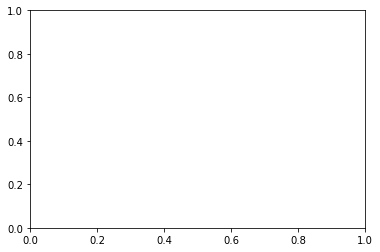

In [26]:
df.boxplot('price')


Oops. What went wrong? 

The error message isn't terribly helpful, so let's look at the data.

In [27]:
df.price.head()

0    $2,363
1    $4,380
2      $950
3    $1,800
4    $1,694
Name: price, dtype: object

Aha. We can't do a boxplot of a string! So let's convert it to a number. This is a three-stage process:
* Remove the `$` (replace `$` with an empty string)
* Do the same for the `,`
* Convert to a float. The pandas `astype` function is useful here.

Let's do this and store the output in a new column, `price_numeric`.

In [28]:
df['price_numeric'] = df.price.str.replace('$','').str.replace(',','').astype(float)

/var/folders/bh/4zzy2ycd00q12kr_sv2j5cxr0000gn/T/ipykernel_81543/2425117574.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price_numeric'] = df.price.str.replace('$','').str.replace(',','').astype(float)


<AxesSubplot:>

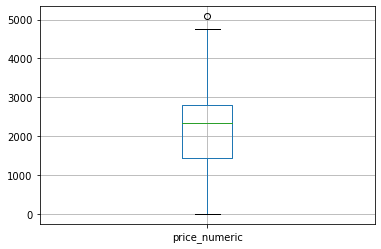

In [29]:
df.boxplot('price_numeric')

We can also break it out by neighborhood using the `by` argument.

But what's the problem here?

<AxesSubplot:title={'center':'price_numeric'}, xlabel='neighborhood'>

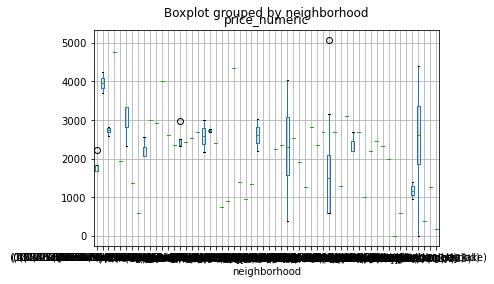

In [30]:
df.boxplot('price_numeric', by='neighborhood')

There are several ways to examine the contents of a pandas DataFrame column. `unique()` can be useful.

Here, we see that there isn't a fixed set of neighborhood names, and so further cleaning would be needed.

In [31]:
df.neighborhood.unique()

array([' (550 N. Figueroa st., Los Angeles, CA)', ' (central LA 213/323)',
       ' (Echo Park)', ' (Los Angeles)',
       ' (101 Bridewell St, Los Angeles, CA)',
       ' (Hollywood - West Hollywood Adj)', ' (Hollywood)',
       ' (1810 S FAIRFAX Avenue Los Angeles, CA)',
       ' (3205 Los Feliz Boulevard, Los Angeles, CA)',
       ' (1026 S Broadway, Los Angeles, CA)', ' (Silver Lake)',
       ' (1221 W. 3rd St. , Los Angeles, CA)', ' (west hollywood)',
       ' (Stevenson Ranch)', ' (909 W. Temple St., Los Angeles, CA)',
       ' (Colorado)', ' (Pacoima, CA)', ' (NORMANDIE & 38TH)',
       ' (LOS ANGELES)', ' (central LA)',
       ' (Washington state bonney lake)', ' (South Park dtla)',
       ' (531 North Hobart Boulevard, Los Angeles, CA)',
       ' (EAST LOS ANGELES)', ' (Franklin Village)',
       ' (Glendale/Burbank [[OR WITHIN CLOSE PROXIMITY]])',
       ' (Los Angeles, CA)',
       ' (4555 W. Martin Luther King Jr. Blvd Los Angeles, CA)',
       ' (Los Angeles, CA.)',
      

What about the relationship between prices and the apartment size?

<AxesSubplot:xlabel='sq_ft', ylabel='price_numeric'>

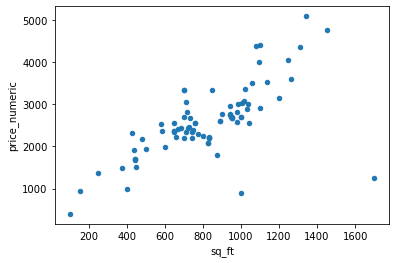

In [32]:
df.plot('sq_ft', 'price_numeric', kind='scatter')

So now we've created a dataframe that extracts all the posts on the first page! 

There's still quite a bit to do. For example:

* We only have one page, and it would be useful to get data from the subsequent pages
* Our neighborhood field is really dirty, so it's hard to do any mapping
* We don't have any information about parking
* We don't have the geographic coordinates (lat/lon)

But let's leave those for future work. 

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Scraping unstructured webpages involves more detective work and trial and error.</li>
  <li>Some will have a consistent format and helpful class codes and html tags. Some won't.</li>
  <li>Your code will need to be robust to missing fields and other inconsistencies in page formatting.</li>
  <li>Be nice! You may need to slow the pace of your requests down.</li>
</ul>
</div>